In [1]:
import pathlib 
import re
import datetime

import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import slr

/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
data_dir = pathlib.Path('~/data/gtsm/surge').expanduser()
src_dir = pathlib.Path(slr.__file__).parent.parent.parent
main_stations_df = pd.read_json(src_dir / 'data' / 'deltares' / 'main_stations.json')
main_stations_df

,id,name,msl-rlr,msl-nap,nap-rlr,alpha,ddl_id,location,psmsl_id,foundation_low,station_low,station_high,latitude,longitude,summary,img,nulpaal,links
0,20,Vlissingen,6976,46,6930,118,VLISSGN,Vlissingen,20,-17.6,2.50,9.00,51.442904,3.597324,This station is located at a quay in Vlissinge...,http://www.openearth.nl/sealevel/static/images...,{'id': '000A4068'},[{'href': 'http://gnss1.tudelft.nl/dpga/statio...
1,22,Hoek van Holland,6987,114,6873,117,HOEKVHLD,Hoek van Holland,22,-3.3,5.27,9.05,51.977536,4.119752,The station in Hoek van Holland is located bes...,http://www.openearth.nl/sealevel/static/images...,"{'id': '000A4021', 'length': 28.35, 'foot': -2...",[{'href': 'http://geodesy.unr.edu/NGLStationPa...
2,23,Den Helder,6962,16,6946,107,DENHDR,Den Helder,23,-5.0,5.00,8.47,52.963769,4.743801,This station is located in the dike of Den Hel...,http://www.openearth.nl/sealevel/static/images...,"{'id': '000A4036', 'length': 17.5, 'foot': -12...",[]
3,24,Delfzijl,6953,130,6823,117,DELFZL,Delfzijl,24,-20.0,1.85,10.18,53.326526,6.933405,The tidal measurement station in Delfzijl is l...,http://www.openearth.nl/sealevel/static/images...,{'id': '000A4041'},[{'href': 'http://geodesy.unr.edu/NGLStationPa...
4,25,Harlingen,7024,110,6914,108,HARLGN,Harlingen,25,-5.4,5.55,8.54,53.175689,5.411273,The tidal station in Harlingen is located in a...,http://www.openearth.nl/sealevel/static/images...,"{'id': '000A4020', 'length': 28, 'foot': -22, ...",[]
5,32,IJmuiden,7014,64,6950,110,IJMDBTHVN,IJmuiden,32,-13.0,4.20,10.35,52.461978,4.556043,IJmuiden is located on the northern part of th...,http://www.openearth.nl/sealevel/static/images...,{'id': '000A4049'},[{'href': 'http://gnss1.tudelft.nl/dpga/statio...


In [3]:
new_ds = xr.open_dataset(data_dir / 'era5_reanalysis_surge_2019_01_v1_monthly_mean.nc')
old_ds = xr.open_dataset(data_dir / 'reanalysis_surge_10min_1979_01_v1_monthly_mean.nc')
old_ds

<xarray.Dataset>
Dimensions:               (stations: 43119)
Coordinates:
    station_x_coordinate  (stations) float64 ...
    station_y_coordinate  (stations) float64 ...
  * stations              (stations) uint16 0 1 2 3 ... 43730 43731 43732 43733
Data variables:
    surge                 (stations) float32 ...

In [4]:
data_path = pathlib.Path(data_dir)

In [5]:
paths = list(sorted(data_path.glob('*surge*.nc')))
paths[0], paths[-1]

(PosixPath('/Users/baart_f/data/gtsm/surge/era5_reanalysis_surge_2019_01_v1_monthly_mean.nc'),
 PosixPath('/Users/baart_f/data/gtsm/surge/reanalysis_surge_10min_2018_12_v1_monthly_mean.nc'))

In [6]:
old_gtsm_df = old_ds[['station_x_coordinate', 'station_y_coordinate', 'stations']].to_pandas()
old_gtsm_gdf = gpd.GeoDataFrame(
    old_gtsm_df,
    geometry=gpd.points_from_xy(old_gtsm_df.station_x_coordinate, old_gtsm_df.station_y_coordinate, crs='EPSG:4326')
)
old_gtsm_gdf = old_gtsm_gdf.reset_index()
old_gtsm_gdf

,stations,station_x_coordinate,station_y_coordinate,geometry
0,0,24.089,34.827,POINT (24.08900 34.82700)
1,1,24.089,34.871,POINT (24.08900 34.87100)
2,2,26.902,35.369,POINT (26.90200 35.36900)
3,3,26.887,35.398,POINT (26.88700 35.39800)
4,4,26.960,35.427,POINT (26.96000 35.42700)
...,...,...,...,...
43114,43729,139.614,33.882,POINT (139.61400 33.88200)
43115,43730,139.204,34.204,POINT (139.20400 34.20400)
43116,43731,139.146,34.204,POINT (139.14600 34.20400)
43117,43732,37.749,-46.978,POINT (37.74900 -46.97800)


In [7]:
new_gtsm_df = new_ds[['station_x_coordinate', 'station_y_coordinate', 'stations', 'station_name']].to_pandas()
new_gtsm_gdf = gpd.GeoDataFrame(
    new_gtsm_df,
    geometry=gpd.points_from_xy(new_gtsm_df.station_x_coordinate, new_gtsm_df.station_y_coordinate, crs='EPSG:4326')
)
new_gtsm_gdf = new_gtsm_gdf.reset_index()
new_gtsm_gdf

,stations,station_x_coordinate,station_y_coordinate,station_name,geometry
0,0,24.089,34.827,b'id_coast_glob_eur_00001 ...,POINT (24.08900 34.82700)
1,1,24.089,34.871,b'id_coast_glob_eur_00002 ...,POINT (24.08900 34.87100)
2,2,26.902,35.369,b'id_coast_glob_eur_00003 ...,POINT (26.90200 35.36900)
3,3,26.887,35.398,b'id_coast_glob_eur_00004 ...,POINT (26.88700 35.39800)
4,4,26.960,35.427,b'id_coast_glob_eur_00005 ...,POINT (26.96000 35.42700)
...,...,...,...,...,...
43729,43729,139.614,33.882,b'islands_99371\r ...,POINT (139.61400 33.88200)
43730,43730,139.204,34.204,b'islands_99417\r ...,POINT (139.20400 34.20400)
43731,43731,139.146,34.204,b'islands_99483\r ...,POINT (139.14600 34.20400)
43732,43732,37.749,-46.978,b'islands_9988\r ...,POINT (37.74900 -46.97800)


<AxesSubplot:>

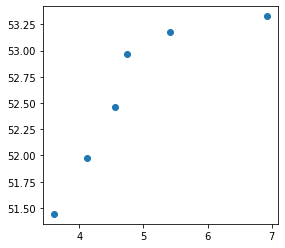

In [8]:
main_stations_gdf = gpd.GeoDataFrame(
    main_stations_df, 
    geometry=gpd.points_from_xy(main_stations_df.longitude, main_stations_df.latitude, crs='EPSG:4326')
)
main_stations_gdf.plot()

In [9]:
# careful here. The first (id_obs stations) have nan values
stations_gtsm_gdf = gpd.sjoin_nearest(main_stations_gdf, old_gtsm_gdf, rsuffix='old', lsuffix='').groupby('name').last()
stations_gtsm_gdf = gpd.sjoin_nearest(stations_gtsm_gdf, new_gtsm_gdf, rsuffix='new', lsuffix='left').groupby('name').last()
stations_gtsm_gdf

/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/geopandas/array.py:341: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/geopandas/array.py:341: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,id,msl-rlr,msl-nap,nap-rlr,alpha,ddl_id,location,psmsl_id,foundation_low,station_low,...,geometry,index_old,stations_left,station_x_coordinate_left,station_y_coordinate_left,index_new,stations_new,station_x_coordinate_new,station_y_coordinate_new,station_name
name,,,,,,,,,,,,,,,,,,,,,
Delfzijl,24,6953,130,6823,117,DELFZL,Delfzijl,24,-20.0,1.85,...,POINT (6.93340 53.32653),39492,39573,6.936,53.328,39573,39573,6.936,53.328,b'NWS_NO_TS_MO_Delfzijl\r ...
Den Helder,23,6962,16,6946,107,DENHDR,Den Helder,23,-5.0,5.00,...,POINT (4.74380 52.96377),39493,39574,4.739,52.961,39574,39574,4.739,52.961,b'NWS_NO_TS_MO_DenHelder\r ...
Harlingen,25,7024,110,6914,108,HARLGN,Harlingen,25,-5.4,5.55,...,POINT (5.41127 53.17569),39504,39585,5.295,53.210,39585,39585,5.295,53.210,b'NWS_NO_TS_MO_Harlingen\r ...
Hoek van Holland,22,6987,114,6873,117,HOEKVHLD,Hoek van Holland,22,-3.3,5.27,...,POINT (4.11975 51.97754),39513,39594,4.124,51.980,39594,39594,4.124,51.980,b'NWS_NO_TS_MO_HoekVanHolland\r ...
IJmuiden,32,7014,64,6950,110,IJMDBTHVN,IJmuiden,32,-13.0,4.20,...,POINT (4.55604 52.46198),39519,39600,4.548,52.463,39600,39600,4.548,52.463,b'NWS_NO_TS_MO_Ijmuiden\r ...
Vlissingen,20,6976,46,6930,118,VLISSGN,Vlissingen,20,-17.6,2.50,...,POINT (3.59732 51.44290),39543,39624,3.596,51.453,39624,39624,3.596,51.453,b'NWS_NO_TS_MO_Vlissingen\r ...


In [10]:
dfs = []
for path in paths:
    ds = xr.open_dataset(path)
    df_i = stations_gtsm_gdf.copy()
    # find the correct index for the stations
    if 'era5' in str(path):
        idx = stations_gtsm_gdf.index_new.values
    elif '10min' in str(path):
        idx = stations_gtsm_gdf.index_old.values
    df_i['surge'] = ds.surge[idx]
    df_i['path'] = str(path)
    dfs.append(df_i.reset_index())
    ds.close()

In [11]:
gtsm_recent_df = pd.concat(dfs)

In [12]:
path

PosixPath('/Users/baart_f/data/gtsm/surge/reanalysis_surge_10min_2018_12_v1_monthly_mean.nc')

In [13]:
path_pattern = re.compile(r'surge_(10min_)?(?P<year>\d+)_(?P<month>\d+)_v1_monthly_mean.nc')
year_month_df = gtsm_recent_df.path.apply(lambda path: pd.Series(path_pattern.search(path).groupdict()))
gtsm_recent_df[['year', 'month']] = year_month_df
gtsm_recent_df['year'] = gtsm_recent_df['year'].apply(lambda x: int(x))
gtsm_recent_df['month'] = gtsm_recent_df['month'].apply(lambda x: int(x))



In [14]:
gtsm_recent_df['t'] = gtsm_recent_df.apply(lambda row: datetime.datetime(int(row['year']), int(row['month']), 1), axis=1)

gtsm_recent_df = gtsm_recent_df.sort_values('t')

gtsm_recent_df

,name,id,msl-rlr,msl-nap,nap-rlr,alpha,ddl_id,location,psmsl_id,foundation_low,...,index_new,stations_new,station_x_coordinate_new,station_y_coordinate_new,station_name,surge,path,year,month,t
5,Vlissingen,20,6976,46,6930,118,VLISSGN,Vlissingen,20,-17.6,...,39624,39624,3.596,51.453,b'NWS_NO_TS_MO_Vlissingen\r ...,-0.016918,/Users/baart_f/data/gtsm/surge/reanalysis_surg...,1979,1,1979-01-01
0,Delfzijl,24,6953,130,6823,117,DELFZL,Delfzijl,24,-20.0,...,39573,39573,6.936,53.328,b'NWS_NO_TS_MO_Delfzijl\r ...,-0.041117,/Users/baart_f/data/gtsm/surge/reanalysis_surg...,1979,1,1979-01-01
1,Den Helder,23,6962,16,6946,107,DENHDR,Den Helder,23,-5.0,...,39574,39574,4.739,52.961,b'NWS_NO_TS_MO_DenHelder\r ...,-0.009794,/Users/baart_f/data/gtsm/surge/reanalysis_surg...,1979,1,1979-01-01
2,Harlingen,25,7024,110,6914,108,HARLGN,Harlingen,25,-5.4,...,39585,39585,5.295,53.210,b'NWS_NO_TS_MO_Harlingen\r ...,-0.012795,/Users/baart_f/data/gtsm/surge/reanalysis_surg...,1979,1,1979-01-01
3,Hoek van Holland,22,6987,114,6873,117,HOEKVHLD,Hoek van Holland,22,-3.3,...,39594,39594,4.124,51.980,b'NWS_NO_TS_MO_HoekVanHolland\r ...,-0.011499,/Users/baart_f/data/gtsm/surge/reanalysis_surg...,1979,1,1979-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,Den Helder,23,6962,16,6946,107,DENHDR,Den Helder,23,-5.0,...,39574,39574,4.739,52.961,b'NWS_NO_TS_MO_DenHelder\r ...,0.062967,/Users/baart_f/data/gtsm/surge/era5_reanalysis...,2021,12,2021-12-01
2,Harlingen,25,7024,110,6914,108,HARLGN,Harlingen,25,-5.4,...,39585,39585,5.295,53.210,b'NWS_NO_TS_MO_Harlingen\r ...,0.076140,/Users/baart_f/data/gtsm/surge/era5_reanalysis...,2021,12,2021-12-01
3,Hoek van Holland,22,6987,114,6873,117,HOEKVHLD,Hoek van Holland,22,-3.3,...,39594,39594,4.124,51.980,b'NWS_NO_TS_MO_HoekVanHolland\r ...,0.049677,/Users/baart_f/data/gtsm/surge/era5_reanalysis...,2021,12,2021-12-01
4,IJmuiden,32,7014,64,6950,110,IJMDBTHVN,IJmuiden,32,-13.0,...,39600,39600,4.548,52.463,b'NWS_NO_TS_MO_Ijmuiden\r ...,0.061915,/Users/baart_f/data/gtsm/surge/era5_reanalysis...,2021,12,2021-12-01


In [15]:
stations_mean_df = gtsm_recent_df.groupby(['t']).mean()[['latitude', 'longitude', 'surge', 'year', 'month']].reset_index()
stations_mean_df['station_name'] = 'Dutch mean'
stations_mean_df['name'] = 'NL'
stations_mean_df['ddl_id'] = 'NL'

olv_toren = shapely.geometry.Point(5.3850577, 52.1551995)
stations_mean_df['geometry'] = olv_toren


In [16]:
gtsm_recent_df = pd.concat([gtsm_recent_df, stations_mean_df])
gtsm_recent_df['days_in_year'] = np.where(gtsm_recent_df.t.dt.is_leap_year, 366, 365)
gtsm_recent_df['days_in_month'] = gtsm_recent_df.t.dt.days_in_month

Delfzijl
Den Helder
Harlingen
Hoek van Holland
IJmuiden
NL
Vlissingen


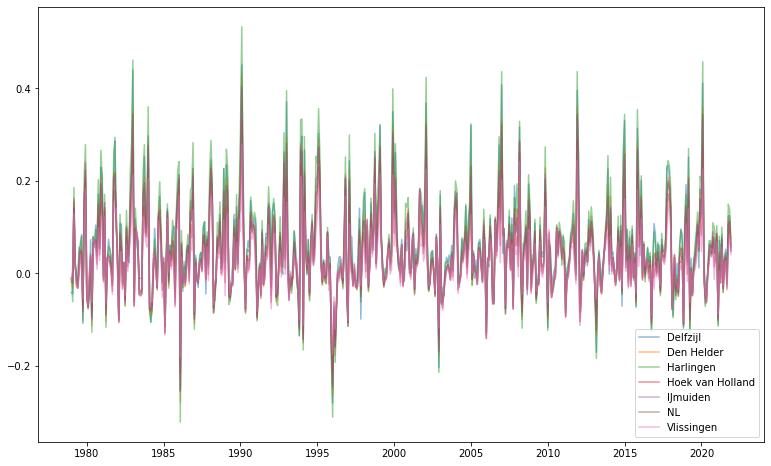

In [17]:
fig, ax = plt.subplots(figsize=(13, 8))
for station, df_i in gtsm_recent_df.groupby('name'):
    print(station)
    ax.plot(df_i.t, df_i.surge, label=station, alpha=0.5)
ax.legend()


In [18]:
nl_df = gtsm_recent_df.query('name == "NL"').sort_values('surge')
known_storms = pd.DataFrame([
    {
        't': datetime.datetime(1990, 2, 28),
        'name': 'SR 63'
    },
    {
        't': datetime.datetime(1983, 2, 1),
        'name': 'SR 56, 57, 58'
    },
    {
        't': datetime.datetime(2020, 2, 1),
        'name': 'SR 98'
    }
])
pd.concat([
    nl_df[['t', 'surge']].head(),
    nl_df[['t', 'surge']].tail()
])


,t,surge
85,1986-02-01,-0.250816
204,1996-01-01,-0.246014
287,2002-12-01,-0.169419
206,1996-03-01,-0.157823
203,1995-12-01,-0.143814
336,2007-01-01,0.322566
493,2020-02-01,0.343519
395,2011-12-01,0.343967
48,1983-01-01,0.344125
133,1990-02-01,0.403693


In [19]:
# groupby date
columns = [pd.Grouper(freq='AS'), 'name', 'ddl_id']
# surge * days per month / days per year (month fraction of year)
gtsm_recent_df['surge_year_part'] = gtsm_recent_df['surge'] * (gtsm_recent_df['days_in_month'] / gtsm_recent_df['days_in_year'])
# if we sum fraction per year over months then we have mean surge over year, weighted by month lengths
annual_mean_df = gtsm_recent_df.set_index('t').groupby(columns, dropna=False)[['surge_year_part']].sum().reset_index()
# rename column to surge
annual_mean_df = annual_mean_df.rename(columns={"surge_year_part": "surge"})



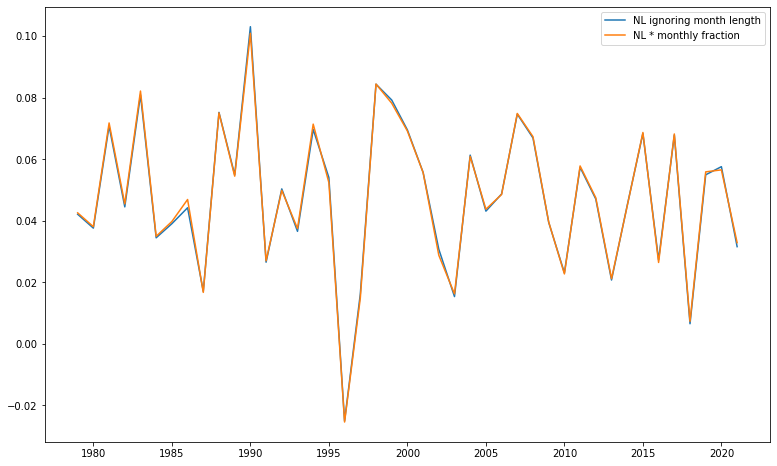

In [20]:
fig, ax = plt.subplots(figsize=(13, 8))
for station, df_i in gtsm_recent_df.groupby('name'):
    if station != 'NL':
        continue

    # group by year, label at start of the year
    # Show the effect of taking into account proper monthly means
    annual_mean_df_i = df_i.set_index('t').groupby(pd.Grouper(freq='AS')).mean()
    ax.plot(annual_mean_df_i.index, annual_mean_df_i.surge, label=station + " ignoring month length")
    annual_mean_df_i = annual_mean_df.query(f"name == '{station}'")
    ax.plot(annual_mean_df_i.t, annual_mean_df_i.surge, label=station + " * monthly fraction")

ax.legend()

In [21]:
monthly_mean_df = gtsm_recent_df[['t', 'name', 'psmsl_id', 'ddl_id', 'latitude', 'longitude', 'station_name', 'surge']]
monthly_mean_df.to_csv(src_dir / 'data' / 'deltares' / 'gtsm' / 'gtsm_surge_monthly_mean_main_stations.csv')


In [22]:
annual_mean_df.to_csv(src_dir / 'data' / 'deltares' / 'gtsm' / 'gtsm_surge_annual_mean_main_stations.csv')


In [23]:
annual_mean_df

,t,name,ddl_id,surge
0,1979-01-01,Delfzijl,DELFZL,0.041702
1,1979-01-01,Den Helder,DENHDR,0.045498
2,1979-01-01,Harlingen,HARLGN,0.057113
3,1979-01-01,Hoek van Holland,HOEKVHLD,0.036467
4,1979-01-01,IJmuiden,IJMDBTHVN,0.044142
...,...,...,...,...
296,2021-01-01,Harlingen,HARLGN,0.048043
297,2021-01-01,Hoek van Holland,HOEKVHLD,0.023542
298,2021-01-01,IJmuiden,IJMDBTHVN,0.031140
299,2021-01-01,NL,NL,0.032905


In [24]:
monthly_mean_df

,t,name,psmsl_id,ddl_id,latitude,longitude,station_name,surge
5,1979-01-01,Vlissingen,20.0,VLISSGN,51.442904,3.597324,b'NWS_NO_TS_MO_Vlissingen\r ...,-0.016918
0,1979-01-01,Delfzijl,24.0,DELFZL,53.326526,6.933405,b'NWS_NO_TS_MO_Delfzijl\r ...,-0.041117
1,1979-01-01,Den Helder,23.0,DENHDR,52.963769,4.743801,b'NWS_NO_TS_MO_DenHelder\r ...,-0.009794
2,1979-01-01,Harlingen,25.0,HARLGN,53.175689,5.411273,b'NWS_NO_TS_MO_Harlingen\r ...,-0.012795
3,1979-01-01,Hoek van Holland,22.0,HOEKVHLD,51.977536,4.119752,b'NWS_NO_TS_MO_HoekVanHolland\r ...,-0.011499
...,...,...,...,...,...,...,...,...
511,2021-08-01,NL,NaN,NL,52.558067,4.893600,Dutch mean,0.036937
512,2021-09-01,NL,NaN,NL,52.558067,4.893600,Dutch mean,-0.021185
513,2021-10-01,NL,NaN,NL,52.558067,4.893600,Dutch mean,0.105875
514,2021-11-01,NL,NaN,NL,52.558067,4.893600,Dutch mean,0.113184
